In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse,
               cowplot,patchwork,psych,
               beeswarm,ggbeeswarm,data.table,ggridges,rjson,ggupset,plotly,reticulate,
               plot3D,RColorBrewer,mapproj,mapdata,ggrepel,ggmap,ggalt)

In [2]:
select_first <- function(input_list) {
    input_list = sort(input_list)
    return(input_list[1])
}

## for each Tara sample that we parsed in this output folder, we need to pull
## the transcripts classified as Phaeocystis by the combined database (phaeo_all)
## and then see what those sample transcripts are classified by according to
## the other databases
# Replace this base directory with the path to your own Phaeocystis mapping
base_dir = "/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/scripts"
all_pivoted_species = data.frame()
all_pivoted_genus = data.frame()
all_pivoted_genus_with_labs = data.frame()
for (curr in list.files(base_dir)) {
    if (!grepl("parsed.csv",curr)) {
        next
    }
    curr_phaeo_file = data.frame(fread(file.path(base_dir,curr),header=TRUE))
    ## select sequences that are supposedly Phaeo according to "all" database
    fragments_class_as_phaeo_in_combo = curr_phaeo_file %>%
    dplyr::filter((grepl("Phaeocy",Genus))) %>%
    dplyr::group_by(transcript_name,TaraSample) %>% 
    dplyr::summarize(PhaeoDB=paste(PhaeoDB,collapse="|")) %>%
    dplyr::mutate(caughtByAllDB = case_when(grepl("phaeo_all",PhaeoDB)~"Yes",
                                            TRUE ~ "No"))
    
    ## find those same transcripts in the combined file and record what we call them
    pivoted_species = curr_phaeo_file %>% 
                  dplyr::right_join(fragments_class_as_phaeo_in_combo %>% 
                                    dplyr::select(TaraSample,transcript_name,caughtByAllDB)) %>%
                  dplyr::mutate(Species = case_when(is.na(Species)~"UnclassifiedAllLevels",
                                                    TRUE ~Species)) %>%
                  tidyr::pivot_wider(id_cols=c("transcript_name","TaraSample","caughtByAllDB"),
                                   names_from="PhaeoDB",
                                   values_from = "Species",values_fn="select_first")
    pivoted_species[is.na(pivoted_species)] = "UnclassifiedAllLevels"
    pivoted_species["Basin"] = unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[1]
    pivoted_species["SizeFract"] = paste0(unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[4:5],
                                         collapse="-")
    
    pivoted_transcripts_genus = curr_phaeo_file %>% 
                  dplyr::right_join(fragments_class_as_phaeo_in_combo %>% 
                                    dplyr::select(TaraSample,
                                                  transcript_name,
                                                  caughtByAllDB)) %>%
                  dplyr::mutate(Genus = case_when(is.na(Genus)~"UnclassifiedAllLevels",
                                                    TRUE ~Genus)) %>%
                  tidyr::pivot_wider(id_cols=c("transcript_name",
                                               "TaraSample","caughtByAllDB"),
                                   names_from="PhaeoDB",
                                   values_from = "Genus",values_fn="select_first")
    
    pivoted_species[is.na(pivoted_species)] = "UnclassifiedAllLevels"
    pivoted_transcripts_genus[is.na(pivoted_transcripts_genus)] = "UnclassifiedAllLevels"
    pivoted_species["Basin"] = unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[1]
    pivoted_species["SizeFract"] = paste0(unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[4:5],
                                         collapse="-")
    
    
    pivoted_transcripts_genus["Basin"] = unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[1]
    pivoted_transcripts_genus["SizeFract"] = paste0(unlist(strsplit(unlist(strsplit(curr,
                                                                                    "_parsed.csv"))[1],"-"))[4:5],
                                         collapse="-")
    
    all_pivoted_genus = all_pivoted_genus %>% dplyr::bind_rows(pivoted_transcripts_genus)
    
        
    pivoted_transcripts_genus = curr_phaeo_file %>% 
                  dplyr::right_join(fragments_class_as_phaeo_in_combo %>% 
                                    dplyr::select(TaraSample,transcript_name,caughtByAllDB)) %>%
                  dplyr::mutate(Genus = case_when(is.na(Genus)~"UnclassifiedAllLevels",
                                                    TRUE ~Genus)) %>%
                  tidyr::pivot_wider(id_cols=c("transcript_name","TaraSample","caughtByAllDB","Family",
                                               "Phylum","Class"),
                                   names_from="PhaeoDB",
                                   values_from = "Genus",values_fn="select_first")
    
    pivoted_transcripts_genus["Basin"] = unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[1]
    pivoted_transcripts_genus["SizeFract"] = paste0(unlist(strsplit(unlist(strsplit(curr,"_parsed.csv"))[1],"-"))[4:5],
                                         collapse="-")
    
    all_pivoted_genus_with_labs = all_pivoted_genus_with_labs %>% dplyr::bind_rows(pivoted_transcripts_genus)
    all_pivoted_species = all_pivoted_species %>% dplyr::bind_rows(pivoted_species)
}

In [3]:
## From Python code/notebook `02FIG_Phaeocystis_data`

abund_frame = read.csv("short_code_abund_mean_cov_9July2023.csv")

In [4]:
abund_frame = abund_frame %>% dplyr::filter((Depth=="SRF")&(SizeFract %in% c("Small","Largest"))) 

In [10]:
list_ggplots=list()

## LATITUDE AND LONGITUDE OF THE MAJOR OCEANS ##
# source: https://www.marineregions.org/gazetteer.php?p=details&id=8562
ocean_coords = data.frame("Oceans"=c("SPO","NPO","NAO","SAO","IO","SO","MS","RS"),
           "Latitude"=c(-30.098,26.95235,31.7771,-33.73345,-27.26765,-68.03982,38.02360535,20.56524),
           "Longitude"=c(-143.06093,-169.38414,-40.24965,-18.83777,79.60243,-26.63286,15.09230423,38.57739))


counter=1
oceans=unique(abund_frame$ShortCode)
latitudes=c()
longitudes=c()
for (counter in c(1:length(oceans))) {
    curr_ocean=oceans[counter]
    list_ggplots[[counter]] = ggplot(abund_frame %>% dplyr::left_join(ocean_coords,
                                                           by = c("ShortCode"="Oceans")) %>%
                                     dplyr::filter(ShortCode==curr_ocean) %>%
                          dplyr::mutate(Latitude=case_when(SizeFract=="Largest" ~ Latitude+10,
                                                           TRUE ~ Latitude),
                                        Longitude=case_when(PhaeoDB=="phaeo_all"~Longitude+20,
                                                            PhaeoDB=="colonies_phaeo"~Longitude-20,
                                                            TRUE~Longitude))) +
        geom_bar(aes(x = SizeFract, y = TotalAll,fill = PhaeoDB,
                 group=paste0(PhaeoDB,SizeFract)),stat = "identity",position="dodge") +
        scale_fill_manual(values=c("black","#c2bdf5","#fabfb7"),breaks=c("phaeo_all","colonies_phaeo",
                                                                "free_phaeo"),
                          labels = c("Full database", "Colony formers", "Free-living"),
                          name="Database")+
        scale_size(range=c(0.25,15),name="Total coverage of\nproteins from metagenome") + 
        guides(fill=guide_legend(override.aes = c(size=6,pch=21))) + theme_classic(base_size=8)+ theme(
  panel.background = element_rect(fill = "transparent",
                                  colour = NA_character_), # necessary to avoid drawing panel outline
  panel.grid.major = element_blank(), # get rid of major grid
  panel.grid.minor = element_blank(), # get rid of minor grid
  plot.background = element_rect(fill = "transparent",
                                 colour = NA_character_), # necessary to avoid drawing plot outline
  legend.background = element_rect(fill = "transparent"),
  legend.box.background = element_rect(fill = "transparent"),
  legend.key = element_rect(fill = "transparent")
) + ggtitle(curr_ocean) + xlab("") + ylab("") + #ylab("Total protein\ncoverage")+ 
    scale_y_continuous(labels = function(x) format(x, scientific = TRUE))
    latitudes=c(latitudes,(abund_frame %>% dplyr::left_join(ocean_coords,
                                                           by = c("ShortCode"="Oceans")) %>%
                                     dplyr::filter(ShortCode==curr_ocean))$Latitude[1])
    longitudes=c(longitudes,(abund_frame %>% dplyr::left_join(ocean_coords,
                                                           by = c("ShortCode"="Oceans")) %>%
                                     dplyr::filter(ShortCode==curr_ocean))$Longitude[1])
}

Saving 6.67 x 6.67 in
image


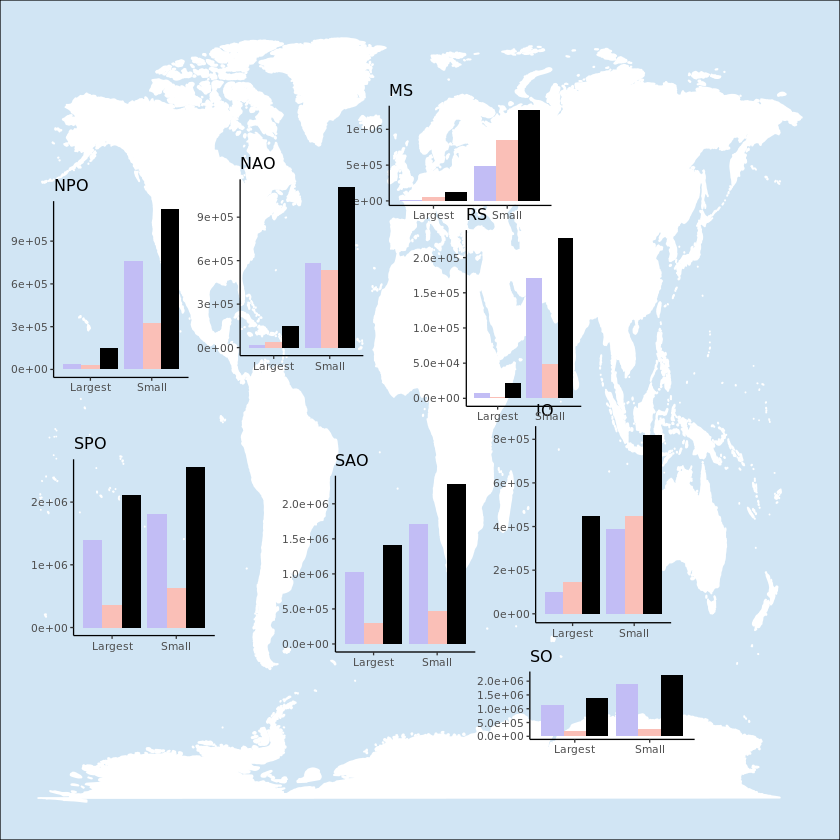

In [11]:
r_earth=6378
convert_lat <- function(latitude_number,dy) {
    new_lat=latitude_number  + (dy / r_earth) * (180 / pi)
    if (new_lat > 80) {
        return(75)
    }
    if (new_lat < -80) {
        return(-80)
    }
    return(new_lat)
}

sam_cols <- c("black","#78db7e","#8965ef","#f0c017",
                                                  "#961480","#01813e","#aa000d",
                                                  "#758000","#ff7ca4","#804216",
                                                  "#a2729c",
                   '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', 
                   '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                   '#9a6324', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000')
sam_cols=c("#ffe4e1","#FAA0A0","#FA8072",#"#E3735E",
           "#E34234",
           "#DC143C","#E3242B","#CC5500", "#C04000",#"#880808",
           "#A42A04",
           "#800022","#E6E6FA","#CBC3E3","#CF9FFF","#DA70D6","#800080","black","white")
world_map <- map_data("world")
med_map <- world_map %>% dplyr::filter((lat > 30) & (lat < 45) & (long > -5) & (long < 20))
so_map <- world_map %>% dplyr::filter((lat < -45) & (lat > min(world_map$lat)) & (long < -55) & (long > -75))

## LATITUDE AND LONGITUDE OF THE MAJOR OCEANS ##
# source: https://www.marineregions.org/gazetteer.php?p=details&id=8562
ocean_coords = data.frame("Oceans"=c("SPO","NPO","NAO","SAO","IO","SO","MS","RS"),
           "Latitude"=c(-30.098,26.95235,31.7771,-33.73345,-27.26765,-68.03982,38.02360535,20.56524),
           "Longitude"=c(-143.06093,-169.38414,-40.24965,-18.83777,79.60243,-26.63286,15.09230423,38.57739))


convert_lon <- function(longitude,latitude,dx) {
    return(longitude + (dx / r_earth) * (180 / pi) / cos(latitude * pi/180))
}
ggplot(abund_frame %>% dplyr::left_join(ocean_coords,
                                                       by = c("ShortCode"="Oceans")) %>%
                      dplyr::mutate(Latitude=case_when(SizeFract=="Largest" ~ Latitude+10,
                                                       TRUE ~ Latitude),
                                    Longitude=case_when(PhaeoDB=="phaeo_all"~Longitude+20,
                                                        PhaeoDB=="colonies_phaeo"~Longitude-20,
                                                        TRUE~Longitude)))+
    geom_polygon(data = world_map, aes(x=long,y=lat,group=group),fill="white", colour = "white") + 
    theme_void(base_size=12)+
    #geom_rect(aes(xmin=-5,xmax=50,ymin=15,ymax=50),fill="transparent",color="black",linetype="dotdash") +
    ggmap::inset(grob = ggplotGrob(list_ggplots[[1]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[1],-3000), ymax = convert_lat(latitudes[1],3500), 
              xmin = convert_lon(longitudes[1],latitudes[1],-5000),
              xmax = convert_lon(longitudes[1],latitudes[1],5000))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[2]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[2],0), ymax = convert_lat(latitudes[2],6000), 
              xmin = convert_lon(longitudes[2],latitudes[2],-5000),
              xmax = convert_lon(longitudes[2],latitudes[2],5000))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[3]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[3],-3000), ymax = convert_lat(latitudes[3],3000), 
              xmin = convert_lon(longitudes[3],latitudes[3],-7000),
              xmax = convert_lon(longitudes[3],latitudes[3],2000))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[4]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[4],-3000), ymax = convert_lat(latitudes[4],3000), 
              xmin = convert_lon(longitudes[4],latitudes[4],-3500),
              xmax = convert_lon(longitudes[4],latitudes[4],6500))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[5]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[5],-3000), ymax = convert_lat(latitudes[5],3000), 
              xmin = convert_lon(longitudes[5],latitudes[5],-5000),
              xmax = convert_lon(longitudes[5],latitudes[5],5000))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[6]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[6],-3000), ymax = convert_lat(latitudes[6],3000), 
              xmin = convert_lon(longitudes[6],latitudes[6],-5000),
              xmax = convert_lon(longitudes[6],latitudes[6],5000))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[7]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[7],-2000), ymax = convert_lat(latitudes[7],2000), 
              xmin = convert_lon(longitudes[7],latitudes[7],2000),
              xmax = convert_lon(longitudes[7],latitudes[7],7000))+
    ggmap::inset(grob = ggplotGrob(list_ggplots[[8]]+theme(legend.position="none")), 
              ymin = convert_lat(latitudes[8],-3000), ymax = convert_lat(latitudes[8],3000), 
              xmin = convert_lon(longitudes[8],latitudes[8],-5000),
              xmax = convert_lon(longitudes[8],latitudes[8],5000))+
    #coord_map(projection="conic",lat0=30,
    #          xlim=c(-180,180),ylim=c(-90,90))+
    #ggalt@::coord_proj("+proj=robin +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m") + #ggalt
    theme(panel.background = element_rect(fill = "#D1E5F4"),
                                                     panel.border=element_blank())

ggsave("new_phaeo_map.pdf")#,width=10,height=7,units="in")